In [26]:
from google.colab import drive
drive.mount('/content/drive')

feature_path = '/content/drive/My Drive/SIF/features.csv'
train_path = '/content/drive/My Drive/SIF/train.csv'
test_path = '/content/drive/My Drive/SIF/test.csv'

import pandas as pd

features_df = pd.read_csv(feature_path)
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Exploration

In [27]:
# Loading and merging data
train_df['Date'] = pd.to_datetime(train_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])
aggregated_sales = train_df.groupby(['Store', 'Date'], as_index=False)['Weekly_Sales'].sum()
df = pd.merge(aggregated_sales, features_df, on=['Store', 'Date'], how='inner')
#df = df.drop(columns=['MarkDown1', 'MarkDown2' , "MarkDown3", "MarkDown4","MarkDown5"])
df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].fillna(0)

In [28]:
df.head(5)

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,1643690.90,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False
1,1,2010-02-12,1641957.44,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,True
2,1,2010-02-19,1611968.17,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False
3,1,2010-02-26,1409727.59,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,False
4,1,2010-03-05,1554806.68,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,False


## EDA

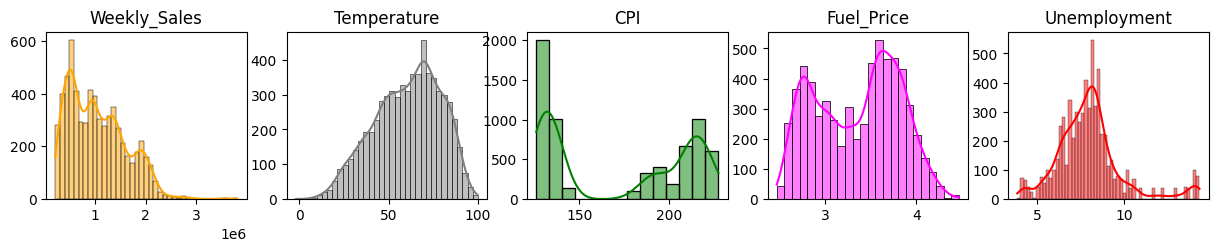

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

columns=['Weekly_Sales','Temperature','CPI','Fuel_Price','Unemployment']
plt.figure(figsize=(15,10))
colors = ['orange', 'grey', 'green', 'magenta','red']
for i,colum  in enumerate(columns,1):
    plt.subplot(4,5,i)
    sns.histplot(df[colum],color=colors[i-1],kde=True)
    plt.title(colum)
    plt.xlabel('')
    plt.ylabel('')

Optimizing Dates

In [30]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Month'] = df['Date'].dt.month
df['Year']  = df['Date'].dt.year
#df.drop('Date',axis=1,inplace=True)

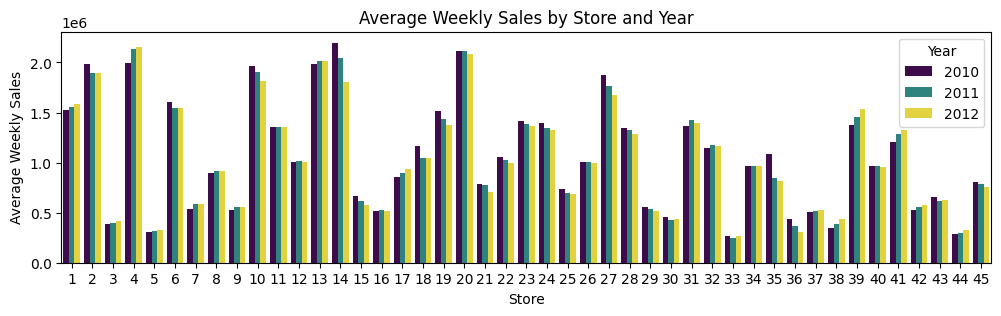

In [18]:
store_year_sales_avg = df.groupby(['Store', 'Year'])['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(12, 3))
sns.barplot(x='Store', y='Weekly_Sales', hue='Year', data=store_year_sales_avg, palette='viridis')
plt.title('Average Weekly Sales by Store and Year')
plt.xlabel('Store')
plt.ylabel('Average Weekly Sales')
plt.show()

Trying to understand Relationship between each columns

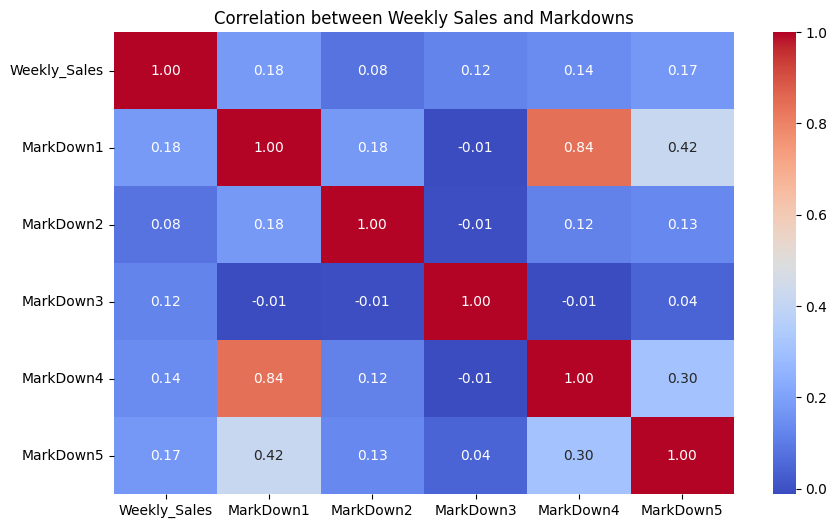

In [21]:
import matplotlib.pyplot as plt

markdown_cols = ['Weekly_Sales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
markdown_corr = df[markdown_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(markdown_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Weekly Sales and Markdowns')
plt.show()


We can see quite a poor relation between any MarkDown values and weekly_sales. We would need some advanced analysis to shed some more light on how these MarkDowns correlate with sales (This is done in the later part of the analysis). We do see that Markdown1 and MarkDown4 have a particularly strong correlation which we will also explore later on.

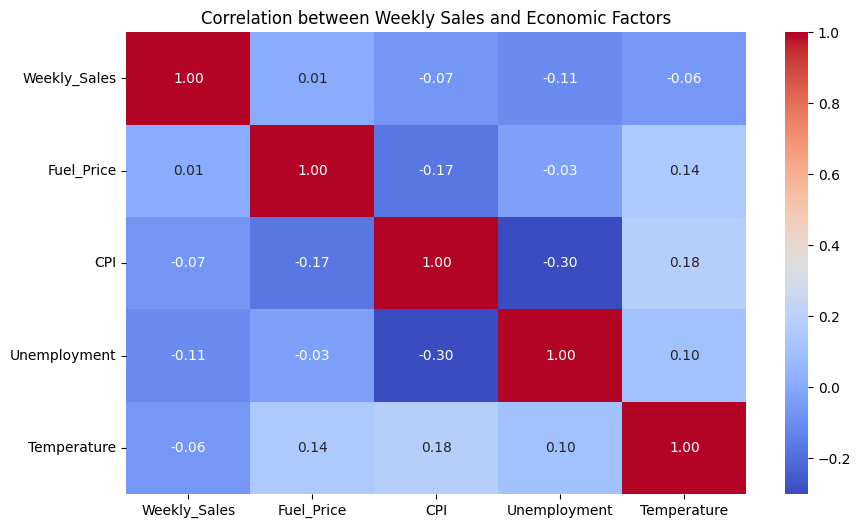

In [22]:
# Weekly_Sales and economic factors
economic_cols = ['Weekly_Sales', 'Fuel_Price', 'CPI', 'Unemployment', 'Temperature']
economic_corr = df[economic_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(economic_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Weekly Sales and Economic Factors')
plt.show()


Similarily, we see weak correlation of economic factors and sales which we will later try to reason.

### Analysis on Holiday data

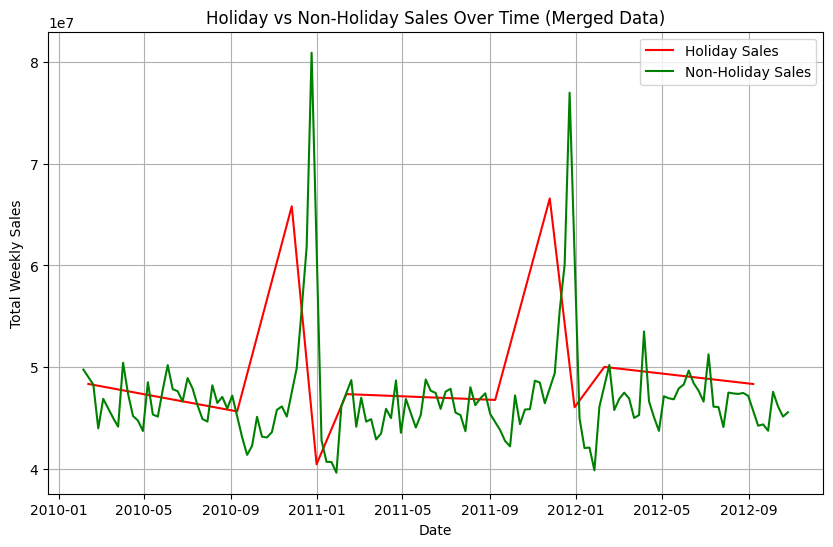

In [31]:
df_holiday = df[df['IsHoliday'] == True]
df_non_holiday = df[df['IsHoliday'] == False]

holiday_sales = df_holiday.groupby('Date')['Weekly_Sales'].sum()
non_holiday_sales = df_non_holiday.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(10, 6))
plt.plot(holiday_sales.index, holiday_sales.values, label='Holiday Sales', color='red')
plt.plot(non_holiday_sales.index, non_holiday_sales.values, label='Non-Holiday Sales', color='green')
plt.title('Holiday vs Non-Holiday Sales Over Time (Merged Data)')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

We Clearly see that on average Holiday Sales are higher than Non-Holiday Sales. However the two huge spikes come from Non- Holiday sale periods. Lets investigate further.

In [34]:
# Trying to fetch when Non-Holiday period sales peak
top_non_holiday_sales = non_holiday_sales.sort_values(ascending=False).head(5)
print(top_non_holiday_sales)

Date
2010-12-24    80931415.60
2011-12-23    76998241.31
2010-12-17    61820799.85
2011-12-16    60085695.94
2010-12-10    55666770.39
Name: Weekly_Sales, dtype: float64


It can be seen that these spikes come during December, just before Chrismas which is why they are not marked as "Holiday" sales. This is understandable as people often shop before and after chrismas and not specifically on the day as they are celebrating with family.

This makes me want to see the average increase in spend in the Holiday Season (Dec 1 to Jan 7)  from 2010 and 2011

In [37]:
holiday_season_2010 = df[(df['Date'] >= '2010-12-01') & (df['Date'] <= '2011-01-07') & (df['IsHoliday'] == True)]
holiday_season_2011 = df[(df['Date'] >= '2011-12-01') & (df['Date'] <= '2012-01-07') & (df['IsHoliday'] == True)]

avg_sales_2010 = holiday_season_2010['Weekly_Sales'].mean()
avg_sales_2011 = holiday_season_2011['Weekly_Sales'].mean()
percentage_increase = ((avg_sales_2011 - avg_sales_2010) / avg_sales_2010) * 100

print(f"Average Holiday Sales (Dec 1, 2010 - Jan 7, 2011): {avg_sales_2010}")
print(f"Average Holiday Sales (Dec 1, 2011 - Jan 7, 2012): {avg_sales_2011}")
print(f"Percentage Increase in Average Sales: {percentage_increase:.2f}%")

Average Holiday Sales (Dec 1, 2010 - Jan 7, 2011): 898500.4222222222
Average Holiday Sales (Dec 1, 2011 - Jan 7, 2012): 1023165.800888889
Percentage Increase in Average Sales: 13.87%


We can uncover a pretty astounding increase of almost 14% in spenditure after just one year!

In [50]:
black_friday_2010 = df[df['Date'] == '2010-11-26']['Weekly_Sales'].sum()
black_friday_2011 = df[df['Date'] == '2011-11-25']['Weekly_Sales'].sum()

percentage_increase = ((black_friday_2011 - black_friday_2010) / black_friday_2010) * 100

print(f"Black Friday Sales on Nov 26, 2010: {black_friday_2010}")
print(f"Black Friday Sales on Nov 25, 2011: {black_friday_2011}")
print(f"Percentage Increase in Black Friday Sales: {percentage_increase:.2f}%")


Black Friday Sales on Nov 26, 2010: 65821003.24
Black Friday Sales on Nov 25, 2011: 66593605.26
Percentage Increase in Black Friday Sales: 1.17%


However, there's barely any difference on the sales of BlackFridays from both years

In [43]:
holiday_season = (df['Date'] >= '2010-12-01') & (df['Date'] <= '2011-01-07') | (df['Date'] >= '2011-12-01') & (df['Date'] <= '2012-01-07')
holiday_sales = df[holiday_season]
non_holiday_sales = df[~holiday_season]
avg_holiday_sales = holiday_sales['Weekly_Sales'].mean()
avg_non_holiday_sales = non_holiday_sales['Weekly_Sales'].mean()
percentage_increase = ((avg_holiday_sales - avg_non_holiday_sales) / avg_holiday_sales) * 100

print(f"Average Holiday Season Sales (Dec 1 - Jan 7): {avg_holiday_sales}")
print(f"Average Non-Holiday Season Sales: {avg_non_holiday_sales}")
print(f"Percentage Increase in Black Friday Sales: {percentage_increase:.2f}%")

Average Holiday Season Sales (Dec 1 - Jan 7): 1230684.8979999998
Average Non-Holiday Season Sales: 1030135.5627124683
Percentage Increase in Black Friday Sales: 16.30%


We can also clearly see that People often on average spend more during Holiday season than the other times of the year.

## Markdown Analysis

Let's graph average Markdown values across all stores over the year

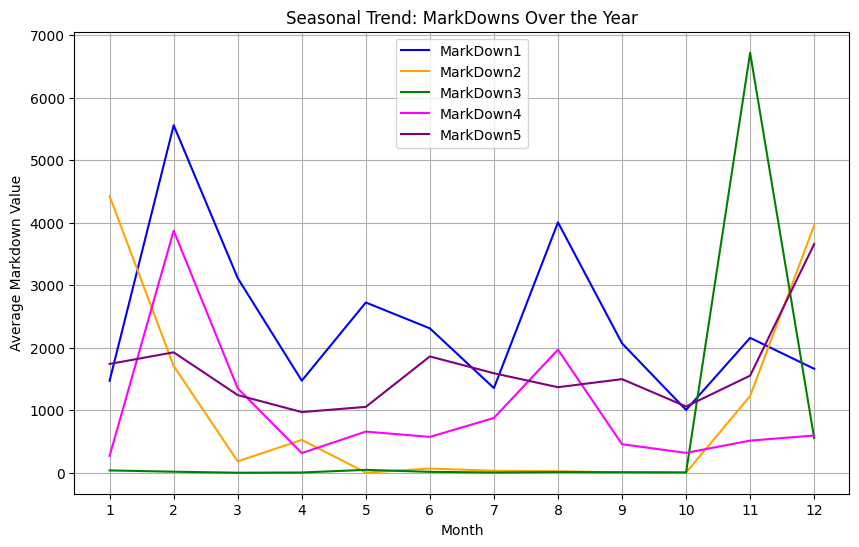

In [53]:
df['Month'] = pd.to_datetime(df['Date']).dt.month

monthly_markdown = df.groupby('Month')[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].mean()

plt.figure(figsize=(10, 6))
plt.plot(monthly_markdown.index, monthly_markdown['MarkDown1'], label='MarkDown1', color='blue')
plt.plot(monthly_markdown.index, monthly_markdown['MarkDown2'], label='MarkDown2', color='orange')
plt.plot(monthly_markdown.index, monthly_markdown['MarkDown3'], label='MarkDown3', color='green')
plt.plot(monthly_markdown.index, monthly_markdown['MarkDown4'], label='MarkDown4', color='magenta')
plt.plot(monthly_markdown.index, monthly_markdown['MarkDown5'], label='MarkDown5', color='purple')

plt.title('Seasonal Trend: MarkDowns Over the Year')
plt.xlabel('Month')
plt.ylabel('Average Markdown Value')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True)
plt.show()

We see that Markdown 1 and 4 seems to have a pretty similar trend with different magnitudes which seem to say that they might be applied to similar categories of products.

Since we could not find a strong correlation between average Markdown prices and sales, let's try to find out the dates when there is a strong relation of each markdown to the weekly sales.

In [56]:
datewise_correlation = df.groupby('Date')[['Weekly_Sales', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].corr().unstack()

md1_correlation = datewise_correlation.loc[:, ('Weekly_Sales', 'MarkDown1')].dropna()
md2_correlation = datewise_correlation.loc[:, ('Weekly_Sales', 'MarkDown2')].dropna()
md3_correlation = datewise_correlation.loc[:, ('Weekly_Sales', 'MarkDown3')].dropna()
md4_correlation = datewise_correlation.loc[:, ('Weekly_Sales', 'MarkDown4')].dropna()
md5_correlation = datewise_correlation.loc[:, ('Weekly_Sales', 'MarkDown5')].dropna()

top_md1 = md1_correlation.nlargest(3)
top_md2 = md2_correlation.nlargest(3)
top_md3 = md3_correlation.nlargest(3)
top_md4 = md4_correlation.nlargest(3)
top_md5 = md5_correlation.nlargest(3)

print("Top 3 strongest correlations for MarkDown1:")
print(top_md1)
print("\nTop 3 strongest correlations for MarkDown2:")
print(top_md2)
print("\nTop 3 strongest correlations for MarkDown3:")
print(top_md3)
print("\nTop 3 strongest correlations for MarkDown4:")
print(top_md4)
print("\nTop 3 strongest correlations for MarkDown5:")
print(top_md5)

Top 3 strongest correlations for MarkDown1:
Date
2012-05-04    0.829747
2011-12-02    0.825105
2011-12-30    0.813435
Name: (Weekly_Sales, MarkDown1), dtype: float64

Top 3 strongest correlations for MarkDown2:
Date
2011-12-30    0.903790
2012-02-17    0.793159
2012-01-06    0.768314
Name: (Weekly_Sales, MarkDown2), dtype: float64

Top 3 strongest correlations for MarkDown3:
Date
2011-11-25    0.887187
2011-12-23    0.869659
2011-12-30    0.799933
Name: (Weekly_Sales, MarkDown3), dtype: float64

Top 3 strongest correlations for MarkDown4:
Date
2012-04-06    0.858499
2011-12-02    0.824040
2012-07-13    0.822063
Name: (Weekly_Sales, MarkDown4), dtype: float64

Top 3 strongest correlations for MarkDown5:
Date
2011-12-02    0.867148
2012-08-24    0.797546
2012-06-08    0.771279
Name: (Weekly_Sales, MarkDown5), dtype: float64


Holiday Season: Markdowns during late Nov and Dec (Black Friday, Christmas) show the strongest correlations with weekly sales across multiple markdowns, highlighting their effectiveness during peak shopping periods. For example, MarkDown3 has the highest correlation on Black Friday (November 25, 2011).

Post-Holiday Promotions: Strong correlations in early 2012 (January to May) suggest that markdowns, such as MarkDown2 and MarkDown1, are highly effective during post-holiday promotions and seasonal clearances. They might be introduced to maintain sales momentum after the holiday season.


Summer Sales Impact: MarkDown4 and MarkDown5 show high correlations during July and August (speciallu July 13, 2012, and August 24, 2012), indicating that markdowns applied during summer clearance or back-to-school promotions are effective at driving sales outside traditional holiday periods.

Diverse Markdown Success: While holiday markdowns dominate, markdowns like MarkDown4 show strong correlations in non-holiday months (like April and July 2012), indicating that well-timed promotions outside peak seasons can still effectively boost sales.









## Analyzing Economic Factors

As we saw earlier, there is no strong correlation between the economic factors and weekly sales. But lets try using the strategy we used for MarkDowns to try to get some insights.

In [58]:
datewise_correlation = df.groupby('Date')[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'Unemployment']].corr().unstack()

temp_correlation = datewise_correlation.loc[:, ('Weekly_Sales', 'Temperature')].dropna()
fuel_correlation = datewise_correlation.loc[:, ('Weekly_Sales', 'Fuel_Price')].dropna()
unemployment_correlation = datewise_correlation.loc[:, ('Weekly_Sales', 'Unemployment')].dropna()

top_temp = temp_correlation.nlargest(3)
top_fuel = fuel_correlation.nlargest(3)
top_unemployment = unemployment_correlation.nlargest(3)

print("Top 3 strongest correlations for Temperature:")
print(top_temp)
print("\nTop 3 strongest correlations for Fuel_Price:")
print(top_fuel)
print("\nTop 3 strongest correlations for Unemployment:")
print(top_unemployment)

Top 3 strongest correlations for Temperature:
Date
2010-04-09    0.140528
2012-03-23    0.108236
2010-05-07    0.092013
Name: (Weekly_Sales, Temperature), dtype: float64

Top 3 strongest correlations for Fuel_Price:
Date
2010-12-03    0.203903
2011-08-26    0.197944
2010-12-10    0.188509
Name: (Weekly_Sales, Fuel_Price), dtype: float64

Top 3 strongest correlations for Unemployment:
Date
2010-02-26    0.038837
2010-03-05    0.021218
2010-02-05    0.007065
Name: (Weekly_Sales, Unemployment), dtype: float64


Even after finding peaks of correlation, we cannot establish a good connection between this factors and weekly sales. While economic factors show weak short-term correlations with weekly sales, they may still have a larger cumulative or long-term impact on retail performance.

# Segmented Data Analysis

In [59]:
df.head()

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Month,Year
0,1,2010-02-05,1643690.90,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2,2010
1,1,2010-02-12,1641957.44,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,True,2,2010
2,1,2010-02-19,1611968.17,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,2,2010
3,1,2010-02-26,1409727.59,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,False,2,2010
4,1,2010-03-05,1554806.68,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,False,3,2010


In [61]:
store_avg_sales = df.groupby('Store')['Weekly_Sales'].mean()

# Classify stores into multiple performance segments (e.g., 4 quartiles: Low, Medium-Low, Medium-High, High)
store_avg_sales_classified = pd.qcut(store_avg_sales, q=4, labels=['Low Performer', 'Medium-Low Performer', 'Medium-High Performer', 'High Performer'])

# Add the classification back to the original dataframe
df['Performance_Segment'] = df['Store'].map(store_avg_sales_classified)
df[['Store', 'Weekly_Sales', 'Performance_Segment']].sample(10)

,Store,Weekly_Sales,Performance_Segment
5507,39,1429829.36,High Performer
4071,29,492932.51,Low Performer
3492,25,618377.79,Medium-Low Performer
3793,27,1762155.79,High Performer
4893,35,961685.98,Medium-Low Performer
4454,32,1187988.64,Medium-High Performer
3249,23,1037476.38,Medium-High Performer
4428,31,1279080.58,Medium-High Performer
1732,13,1877358.86,High Performer
1160,9,558143.53,Low Performer


<ipython-input-73-03de7e499db3>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_trends_by_segment = df.groupby(['Performance_Segment', 'Date'])['Weekly_Sales'].mean().unstack()


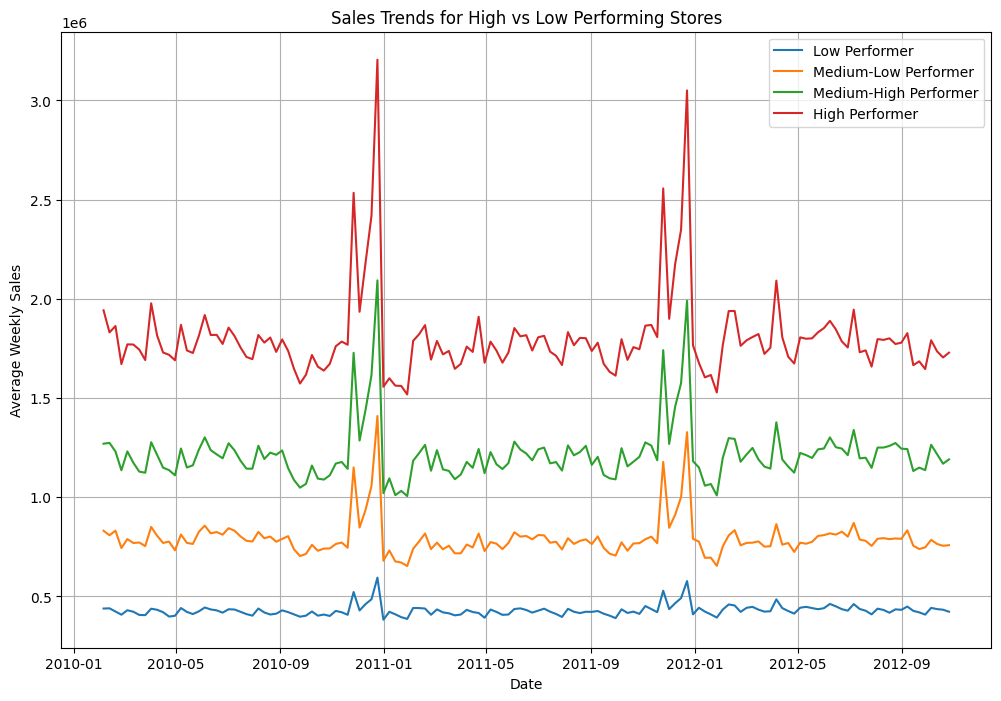

In [73]:
import matplotlib.pyplot as plt

sales_trends_by_segment = df.groupby(['Performance_Segment', 'Date'])['Weekly_Sales'].mean().unstack()
plt.figure(figsize=(12, 8))
for segment in sales_trends_by_segment.index:
    plt.plot(sales_trends_by_segment.loc[segment], label=segment)

plt.title('Sales Trends for High vs Low Performing Stores')
plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

As expected we can clearly see the disparity between high and low performing stores' average weekly sales

<ipython-input-62-95da88236ede>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  markdown_impact = df.groupby('Performance_Segment')[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].mean()


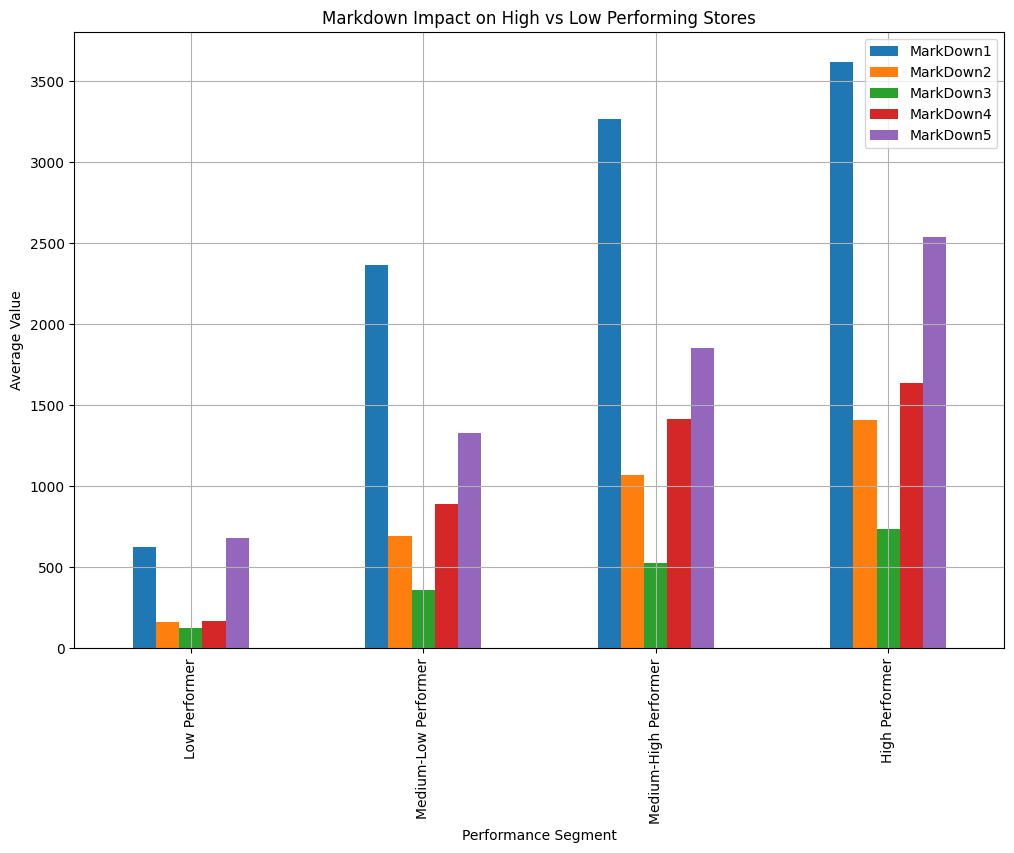

In [62]:
# Group by performance segment and calculate the mean of markdowns and weekly sales
markdown_impact = df.groupby('Performance_Segment')[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].mean()

# Plot the impact of markdowns on high and low performing stores
markdown_impact.plot(kind='bar', figsize=(12, 8))
plt.title('Markdown Impact on High vs Low Performing Stores')
plt.xlabel('Performance Segment')
plt.ylabel('Average Value')
plt.grid(True)
plt.show()

We can see that MarkDown1 has the highest average value across all performance segments, especially for High and Medium-High Performers. MarkDown5 is also prominent. MarkDown2 and MarkDown4 have moderate impacts, while MarkDown3 is relatively consistent but lower in value across all segments.

# Promotion Lift

In [64]:
# Identify periods with significant markdowns (any non-zero markdowns)
df['Markdown_Applied'] = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].sum(axis=1) > 0

# Calculate total sales by date to get an overall view of sales patterns
sales_by_date = df.groupby('Date')['Weekly_Sales'].sum()

markdown_dates = df[df['Markdown_Applied'] == True]['Date'].unique()

# Define a function to analyze pre, during, and post-promotion sales
def get_promotion_impact(markdown_date, window=2):
    """
    Analyze sales before, during, and after a markdown event.
    window: how many weeks before and after to consider as baseline/post-promotion
    """
    # Get pre-promotion, during-promotion, and post-promotion periods
    pre_promotion_period = sales_by_date[(sales_by_date.index < markdown_date) & (sales_by_date.index >= (markdown_date - pd.Timedelta(weeks=window)))]
    during_promotion_period = sales_by_date[sales_by_date.index == markdown_date]
    post_promotion_period = sales_by_date[(sales_by_date.index > markdown_date) & (sales_by_date.index <= (markdown_date + pd.Timedelta(weeks=window)))]

    return (pre_promotion_period.mean() / 1e6, during_promotion_period.mean() / 1e6, post_promotion_period.mean() / 1e6)

promo_lift_data = []

for date in markdown_dates:
    pre_sales, during_sales, post_sales = get_promotion_impact(date)
    lift_during = during_sales - pre_sales
    lift_post = post_sales - pre_sales
    promo_lift_data.append({
        'Date': date,
        'Pre_Sales (in million $)': pre_sales,
        'During Sales (in million $)': during_sales,
        'Post Sales (in million $)': post_sales,
        'Lift During (in million $)': lift_during,
        'Lift Post (in million $)': lift_post
    })

promo_lift_df = pd.DataFrame(promo_lift_data)
promo_lift_df[['Date', 'Pre_Sales (in million $)', 'During Sales (in million $)', 'Post Sales (in million $)', 'Lift During (in million $)', 'Lift Post (in million $)']].head()


,Date,Pre_Sales (in million $),During Sales (in million $),Post Sales (in million $),Lift During (in million $),Lift Post (in million $)
0,2011-11-11,47.255683,48.474225,56.516293,1.218542,9.260610
1,2011-11-18,48.564885,46.438981,57.992081,-2.125904,9.427196
2,2011-11-25,47.456603,66.593605,52.475852,19.137003,5.019249
3,2011-12-02,56.516293,49.390556,57.823422,-7.125736,1.307129
4,2011-12-09,57.992081,55.561148,68.541969,-2.430933,10.549888


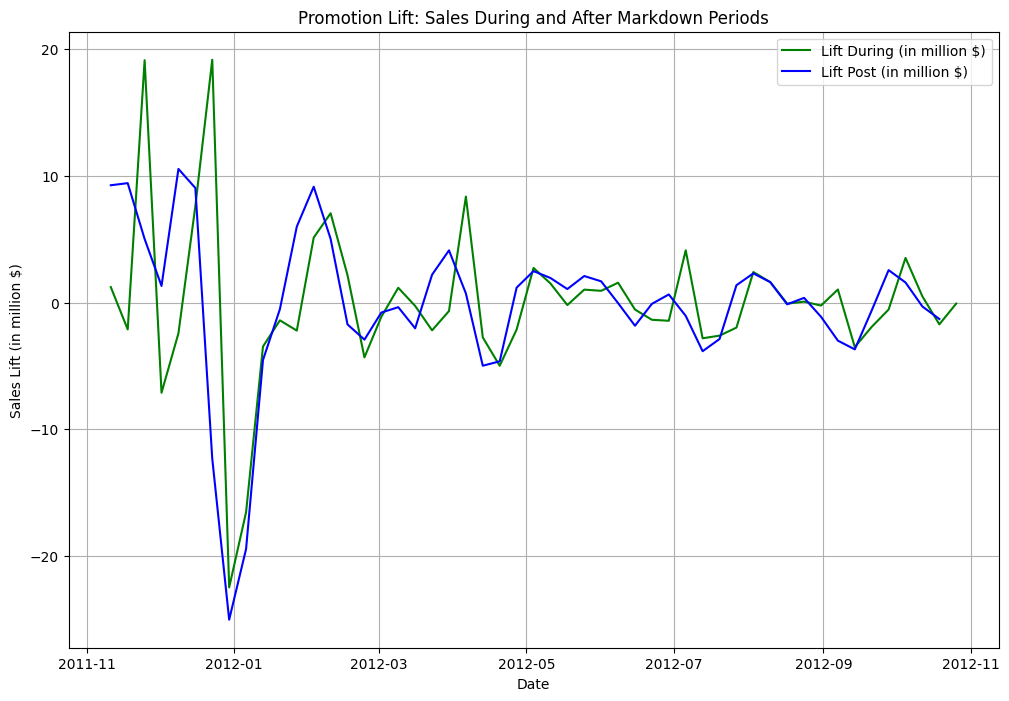

In [65]:
plt.figure(figsize=(12, 8))

plt.plot(promo_lift_df['Date'], promo_lift_df['Lift During (in million $)'], label='Lift During (in million $)', color='green')
plt.plot(promo_lift_df['Date'], promo_lift_df['Lift Post (in million $)'], label='Lift Post (in million $)', color='blue')
plt.title('Promotion Lift: Sales During and After Markdown Periods')
plt.xlabel('Date')
plt.ylabel('Sales Lift (in million $)')
plt.legend()
plt.grid(True)

plt.show()


We can infer the following:

Positive Lift During Promotions: For some periods (likeNovember 25, 2011), there is a significant sales boost during promotions (~19 million), indicating a highly effective markdown. This shows that certain markdowns can substantially increase sales.

Post-Promotion Lift: In most cases, the post-promotion sales also show a positive lift, though typically smaller than the during-promotion lift (like post-promotion sales on November 25, 2011, showed a lift of ~5 million). This suggests that promotions may continue to have a slight residual effect on sales after the markdown ends.

Negative Lift During Some Promotions: In some instances (like December 2, 2011), the promotion results in negative lift during the markdown period (e.g., -7 million), which may indicate that the markdown wasn't effective, or it could imply a cannibalization effect where sales were pulled forward from future weeks.

Overall Impact: Promotions generally have a positive impact both during and post-promotion, but the effect varies across periods. High variance in the lift (both positive and negative) highlights the importance of timing and promotion strategy.

These insights can help fine-tune markdown strategies to maximize promotion effectiveness while minimizing potential cannibalization.

## Fourier Analysis

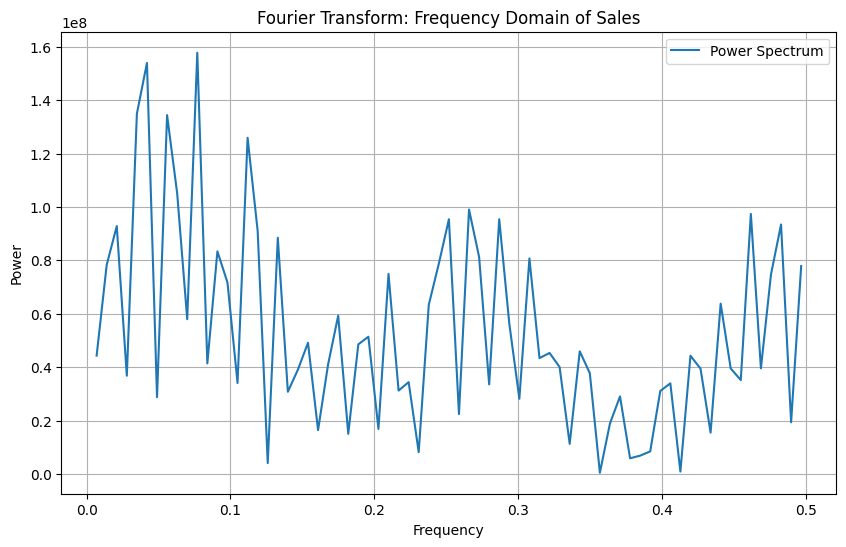

In [63]:
import numpy as np

sales_by_date = df.groupby('Date')['Weekly_Sales'].sum()

sales_detrended = sales_by_date - np.mean(sales_by_date)

# Apply Fourier Transform
sales_fft = np.fft.fft(sales_detrended)

frequencies = np.fft.fftfreq(len(sales_fft))
power_spectrum = np.abs(sales_fft)

# Only consider the positive half of the frequencies (as the other half is symmetrical)
positive_freqs = frequencies[frequencies > 0]
positive_power_spectrum = power_spectrum[frequencies > 0]

plt.figure(figsize=(10, 6))
plt.plot(positive_freqs, positive_power_spectrum, label='Power Spectrum')
plt.title('Fourier Transform: Frequency Domain of Sales')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.legend()
plt.show()

Interpretation:
The peaks around lower frequencies (near 0.1) likely correspond to seasonal trends (e.g., yearly sales patterns due to holidays or promotions).
There are also some smaller peaks at higher frequencies, which could indicate shorter-term cycles, like monthly sales cycles or weekly shopping behaviors.

In [90]:
!pip install PyWavelets
!pip install pywt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


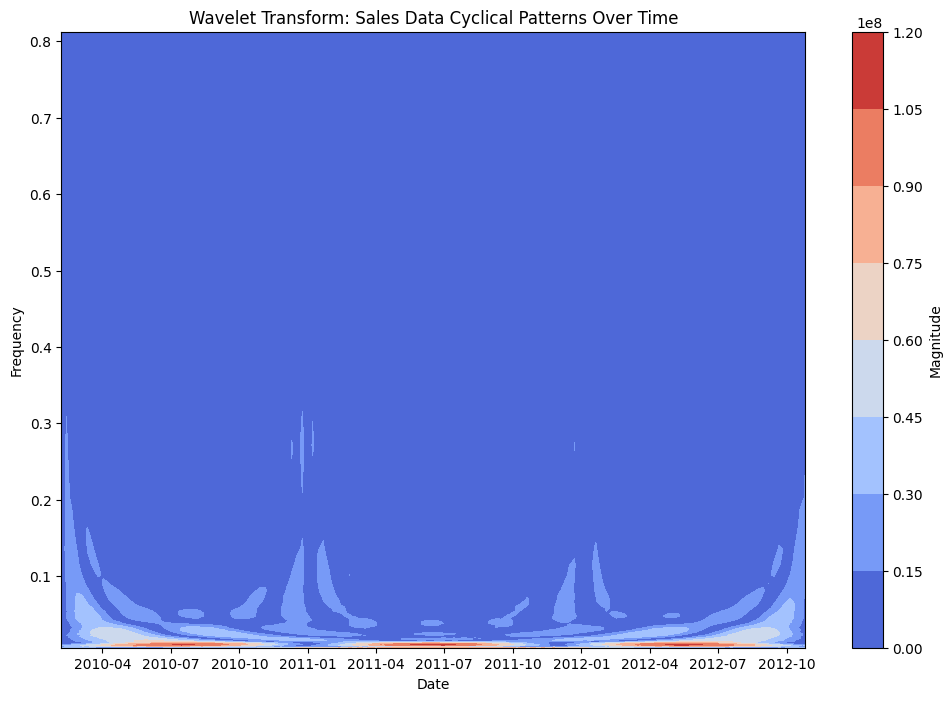

In [91]:
import pywt
import matplotlib.pyplot as plt

sales_by_date = df.groupby('Date')['Weekly_Sales'].sum()

wavelet = 'morl'
scales = np.arange(1, 128)
coefficients, frequencies = pywt.cwt(sales_by_date, scales, wavelet)

plt.figure(figsize=(12, 8))
plt.contourf(sales_by_date.index, frequencies, np.abs(coefficients), cmap='coolwarm')
plt.title('Wavelet Transform: Sales Data Cyclical Patterns Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.colorbar(label='Magnitude')
plt.show()

We can see strong cyclical activity around the holiday season at the end of each year (2010, 2011), where red/orange spots show up at low frequencies (around 0.1). This aligns with annual sales peaks.
Throughout the middle of the year, sales cycles are weaker, which aligns with non-holiday periods.
At higher frequencies (closer to 0.3), there is less pronounced cyclical activity, indicating that weekly or monthly sales patterns are not as strong as the yearly holiday cycles.

# Final Conclusions

1. **Merging Features and Train CSV**:
   - We started by **merging the `features.csv` and `train.csv`** files based on the `Store` and `Date` columns. This step allowed us to combine weekly sales data with economic and markdown information, laying the groundwork for comprehensive analysis.

2. **Elementary Data analysis** :
- Which include graphing out the different columns and seeing trends
- Finding correlation of each column with weekly sales

3. **Markdown Analysis**:
   - We explored the **correlations between markdowns and weekly sales**. **MarkDown1** consistently demonstrated the **strongest correlation** with sales, particularly during peak periods like the holidays.
   - The analysis also highlighted that **high-performing stores** benefitted more from markdowns, particularly from **MarkDown1** and **MarkDown5**, indicating their significant impact on driving sales.

4. **Economic Factors Correlation**:
   - We also analyzed the correlation between **economic factors** (Fuel_Price, Temperature, Unemployment, CPI) and weekly sales. The correlations were generally **weak**, indicating that while these factors may not have a strong immediate impact on sales, they could play a more **long-term role** in influencing consumer behavior.

5. **Seasonal Trends**:
   - We examined markdown patterns throughout the year and found that markdowns peaked during **holiday periods** (late November to December) and **post-holiday sales** in early 2012. **MarkDown1** and **MarkDown4** were particularly effective during **seasonal clearances** in spring and summer.

6. **Promotion Lift Analysis**:
   - We measured the **sales lift before, during, and after markdown periods**. Significant **sales spikes occurred during promotions**, particularly around **holidays** and **post-holiday promotions**. Post-promotion effects varied, with certain periods showing **cannibalization of future sales**.

7. **Fourier and Wavelet Analysis**:
- We applied Fourier Transform to decompose the sales time series and identified strong annual sales patterns with peaks around the holiday season. Wavelet analysis allowed us to examine how these cyclical patterns evolved over time, revealing that holiday-related cycles were the strongest, with other patterns being weaker and less consistent throughout the year.


### Conclusion:
Our analysis highlights the importance of markdown strategies, particularly during key periods like the holidays and post-holiday sales. MarkDown1 emerged as the most effective markdown in driving sustained sales growth. High-performing stores consistently leveraged markdowns more effectively than low-performing ones. Fourier and wavelet analysis confirmed strong seasonal patterns, with sales cycles peaking around the holiday season. While economic factors had weak correlations, they could still influence sales over the long term. This comprehensive analysis can guide more informed markdown strategies and promotional planning for optimized sales performance throughout the year.